In [1]:
import pandas_datareader as web
import datetime as dt
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM

In [ ]:
# 1. Prepare the data

In [11]:
train_start_date = dt.datetime(2012, 1, 1) 
train_end_date = dt.datetime(2021, 1, 1)
stock = 'AAPL'

# Obtain stock data from yahoo finance
stock_prices = web.DataReader(stock, 'yahoo', train_start_date, train_end_date)

## Descriptive methods visualization

Text(0.5, 0, 'Time')

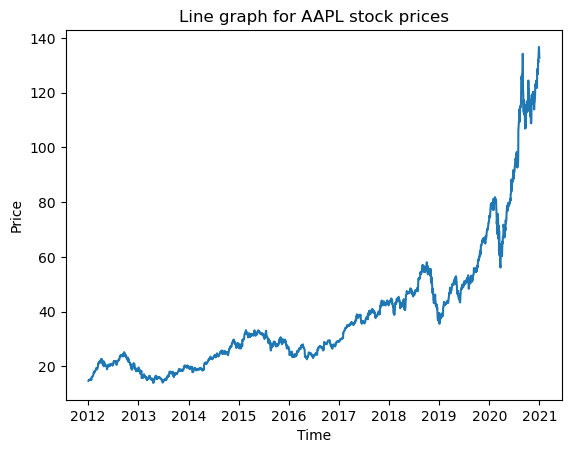

In [15]:
plt.plot(stock_prices["Close"])
plt.title(f"Line graph for {stock} stock prices")
plt.ylabel("Price")
plt.xlabel("Time")

Text(0.5, 0, 'Price')

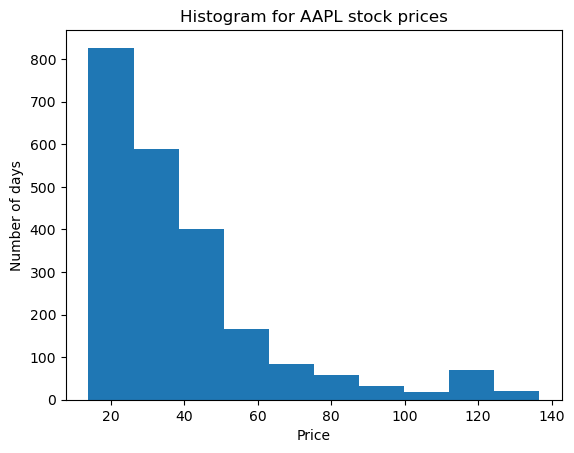

In [16]:
plt.hist(stock_prices["Close"])
plt.title(f"Histogram for {stock} stock prices")
plt.ylabel("Number of days")
plt.xlabel("Price")

Text(0.5, 0, 'Time')

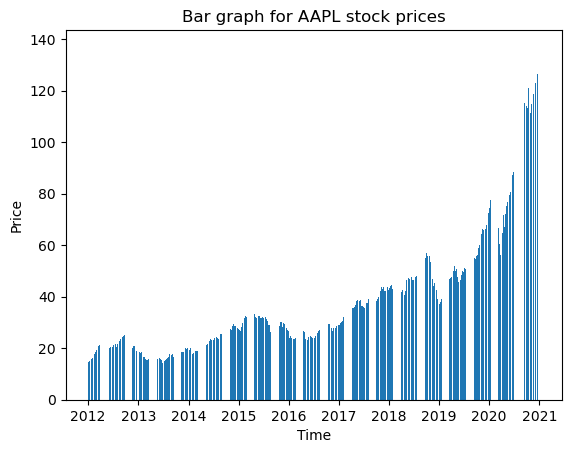

In [17]:
plt.bar(stock_prices.index, stock_prices["Close"])
plt.title(f"Bar graph for {stock} stock prices")
plt.ylabel("Price")
plt.xlabel("Time")

In [20]:
# Scale the data to fit between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close_prices = scaler.fit_transform(stock_prices['Close'].values.reshape(-1, 1))

In [21]:
# Create empty arrays for x and y training data
x_train = []
y_train = []

In [22]:
# Number of days model will look in the past when training
training_days = 30

In [23]:
# Load training data
for x in range(training_days, len(scaled_close_prices)):
    x_train.append(scaled_close_prices[x-training_days:x, 0])
    y_train.append(scaled_close_prices[x, 0]) # Predicted day

In [24]:
# Convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

In [25]:
# Reshape x_train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [26]:
# 2. Choose and build model

In [27]:
# Sequential model
model = Sequential()

In [28]:
# Build model
model.add(LSTM(units=45, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# 3. Fit the model

# Fit model to the training data
model.fit(x_train, y_train, epochs=20, batch_size=24)

Epoch 1/20
94/94 [==============================] - 23s 152ms/step - loss: 0.0066
Epoch 2/20
94/94 [==============================] - 14s 152ms/step - loss: 0.0016
Epoch 3/20
94/94 [==============================] - 14s 151ms/step - loss: 9.6060e-04
Epoch 4/20
94/94 [==============================] - 14s 152ms/step - loss: 0.0013
Epoch 5/20
94/94 [==============================] - 14s 151ms/step - loss: 0.0013
Epoch 6/20
94/94 [==============================] - 14s 152ms/step - loss: 0.0012
Epoch 7/20
94/94 [==============================] - 14s 152ms/step - loss: 9.9604e-04
Epoch 8/20
94/94 [==============================] - 14s 153ms/step - loss: 0.0012
Epoch 9/20
94/94 [==============================] - 14s 152ms/step - loss: 0.0011
Epoch 10/20
94/94 [==============================] - 14s 152ms/step - loss: 9.3871e-04
Epoch 11/20
94/94 [==============================] - 14s 152ms/step - loss: 8.5519e-04
Epoch 12/20
94/94 [==============================] - 14s 153ms/step - loss: 8.15

In [ ]:
# 4. Evaluate model test accuracy

In [30]:
# Analze accuracy of ML model on training data ~80% of total data

# y_train holds trained data

# y_inverse holds data inverse transformed
y_inverse = y_train
y_inverse = pd.DataFrame(y_inverse)
y_inverse = scaler.inverse_transform(y_inverse)

index_y = 0
index_close = 30
accuracy = 0
accuracy_array = []

# Add accuracy values to accuracy_array
for x in y_inverse:
    if (y_inverse[index_y] == stock_prices["Close"][index_close]):
        accuracy_array.append(1)
        index_y += 1
        index_close += 1
    else:
        accuracy_array.append(stock_prices["Close"][index_close]/y_inverse[index_y])
        index_y += 1
        index_close += 1
        
# Add accuracy values and divide by total
accuracy_index = 0

for x in accuracy_array:
    accuracy += accuracy_array[0]
    accuracy_index += 1
    
accuracy = accuracy / 2235
print(f"Training accuracy = {accuracy}")

Training accuracy = 1.0


In [31]:
# Run model on test data ~20% of total data

# Load test data
test_start_date = dt.datetime(2021, 1, 1)
test_end_date = dt.datetime.now()
test_data = web.DataReader(stock, 'yahoo', test_start_date, test_end_date)
actual_prices = test_data['Close'].values
total_price_set = pd.concat((stock_prices['Close'], test_data['Close']), axis=0)

# Scale the data
test_inputs = total_price_set[len(total_price_set) - len(test_data) - training_days:].values
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)

# Create empty array for x test 
x_test = []

# Training days = 30

# Load test data
for x in range(training_days, len(test_inputs)):
    x_test.append(test_inputs[x-training_days:x, 0])
    
# Convert to numpy array
x_test = np.array(x_test)

# Reshape x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# model
predicted_test_prices = model.predict(x_test)

# Reverse the scaler
predicted_test_prices = scaler.inverse_transform(predicted_test_prices)

In [32]:
# Analyze model accuracy on test data

index_test = 0
accuracy_test = 0
accuracy_test_array = []

# Add accuracy values to accuracy array
for x in predicted_test_prices:
    if (predicted_test_prices[index_test] == actual_prices[index_test]):
        accuracy_test_array.append(1)
        index_test += 1
    else:
        if (predicted_test_prices[index_test] > actual_prices[index_test]):
            accuracy_test_array.append(actual_prices[index_test]/predicted_test_prices[index_test])
        if (predicted_test_prices[index_test] < actual_prices[index_test]):
            accuracy_test_array.append(predicted_test_prices[index_test]/actual_prices[index_test])
        index_test += 1
        
# Add accuracy values and divide by total
accuracy_test_index = 0

for x in accuracy_test_array:
    accuracy_test += accuracy_test_array[accuracy_test_index]
    accuracy_test_index += 1
    
accuracy_test = accuracy_test / 453 # Length of test data
print(f"Testing accuracy = {accuracy_test}")

Testing accuracy = [0.9768001]


In [33]:
# Graph non-descriptive model

Text(0, 0.5, 'Price')

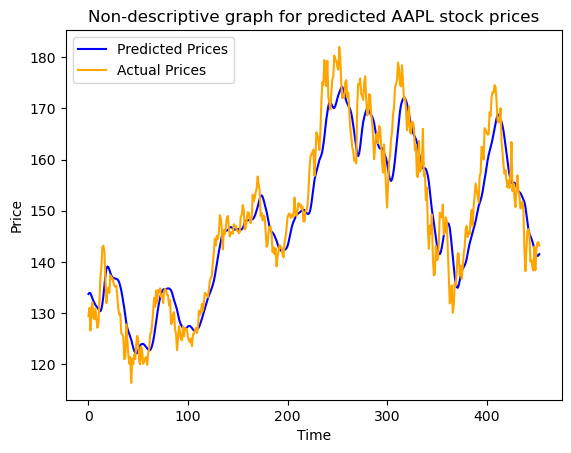

In [44]:
plt.plot(predicted_test_prices, color="blue", label="Predicted Prices")
plt.plot(actual_prices, color="orange", label="Actual Prices")
plt.legend()
plt.title(f"Non-descriptive graph for predicted {stock} stock prices")
plt.xlabel("Time")
plt.ylabel("Price")

In [45]:
# 6. Experiment model by predicting tomorrows stock price

In [62]:
# Run model to predict tomorows stock price

# Get current prices and reshape
current_prices = [test_inputs[len(test_inputs) + 1 - training_days:len(test_inputs+1), 0]]
current_prices = np.array(current_prices)
current_prices = np.reshape(current_prices, (current_prices.shape[0], current_prices.shape[1], 1))

# Predict tomorrows stock price by fitting current prices to model
prediction = model.predict(current_prices)
prediction = scaler.inverse_transform(prediction)
tomorrows_price = float(prediction[0][0])
print(f"Tomorrows stock price for {company} is: ${round(tomorrows_price, 2)}")

Tomorrows stock price for AAPL is: $141.92


In [64]:
# Import to web

In [66]:
#import anvil.server